# Dictionary Learning based Beamformer

Parameters to investigate:
* Number of interferences in training vs testing
* Interferences angles in training vs testing
* Interference power in training vs testing
* Number of snapshots and training samples in training
* Input SNR

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
# print(plt.style.available)
plt.style.use("ggplot")
# plt.style.use("fivethirtyeight")
plt.style.use("seaborn-talk")
from tqdm import tnrange, tqdm_notebook

In [2]:
from dlbeamformer_utilities import compute_steering_vector_ULA, compute_MVDR_weight, check_distortless_constraint, uniform_linear_array, generate_gaussian_samples, generate_gaussian_training_data
from dlbeamformer import MicrophoneArray, BaseDLBeamformer

#### Setup

In [3]:
d = 0.5
n_mics = 10
array_geometry = uniform_linear_array(n_mics=n_mics, spacing=d)
microphone_array = MicrophoneArray(array_geometry)
us = 0
vs = compute_steering_vector_ULA(us, microphone_array)
SNRs = np.arange(0, 31, 10)
n_SNRs = len(SNRs)
noise_sigma = 1

#### Training data

In [4]:
# u_list = [0.29, 0.45]
# n_training_samples = 500
# training_snapshot = 100
# sigma = 10**(20/10)
# training_noise_interference_data = []
# for i_training_sample in range(n_training_samples):
# #     u = np.random.uniform(0, 1)
#     u = np.random.choice(u_list)
# #     vi = np.exp(1j*2*np.pi*d_array*u)
#     vi = compute_steering_vector_ULA(u, microphone_array)
#     ii = np.sqrt(sigma/2)*np.random.randn(1, training_snapshot) + 1j*np.sqrt(sigma/2)*np.random.randn(1, training_snapshot) # interference samples
#     noise = np.sqrt(sigma_n/2)*np.random.randn(n_mics, training_snapshot) + 1j*np.sqrt(sigma_n/2)*np.random.randn(n_mics, training_snapshot) # Gaussian noise samples
#     nv = vi*ii + noise
#     training_noise_interference_data.append(nv)


# training_snapshots = [100, 200, 500]
# u_list = [0.29, 0.45]
# interference_powers = [10]   
# n_interference_list = [1, 2]

training_snapshots = [10, 100]
interference_power_list = [10, 20, 30]
n_interference_list = [1, 2, 3]
n_training_samples = 1
u_step = 0.1
u_list = np.arange(0, 1+1e-6, u_step)

training_snapshots = [200]
interference_power_list = [30]
n_interference_list = [2]
# u_list = [0.29, 0.45]
# u_list = [.3, .4, .5]

training_noise_interference_data_various_snapshots = generate_gaussian_training_data(microphone_array, training_snapshots, n_interference_list, 
                                                                                     u_list, interference_power_list, n_training_samples, noise_sigma)

#### Train baseline dictionary

In [5]:
dictionaries = []
for i_training_snapshot in range(len(training_snapshots)):
    training_noise_interference_data = training_noise_interference_data_various_snapshots[i_training_snapshot]
    dictionary = BaseDLBeamformer(vs)
    dictionary.fit(training_noise_interference_data);
    dictionaries.append(dictionary)

#### Testing

In [6]:
n_trials = 200
snapshots = np.array([10, 20, 30, 40, 60, 100, 200, 500, 1000])
n_snapshots = len(snapshots)
# ui1 = np.random.uniform(0, 1)
# ui2 = np.random.uniform(0, 1)

u_list = [0.29, 0.45]
n_interferences_list = [len(u_list)]

# Wo = Rninv.dot(vs) / (vs.transpose().conjugate().dot(Rninv).dot(vs))

sinr_snr_mvdr = np.zeros((n_SNRs, n_snapshots))
sinr_snr_mpdr = np.zeros((n_SNRs, n_snapshots))
sinr_snr_baseline_mpdr = np.zeros((len(training_snapshots), n_SNRs, n_snapshots))
sinr_snr_baseline_mvdr = np.zeros((len(training_snapshots), n_SNRs, n_snapshots))

for i_SNR in tqdm_notebook(range(n_SNRs), desc="SNRs"):
    sigma_s = 10**(SNRs[i_SNR] / 10)
    Rs = sigma_s * vs.dot(vs.transpose().conjugate())
    
#     SINRopt = ( np.real(Wo.transpose().conjugate().dot(Rs).dot(Wo)) / np.real(Wo.transpose().conjugate().dot(Rn).dot(Wo)) )[0][0]
    
    for i_snapshot in tqdm_notebook(range(n_snapshots), desc="Snapshots", leave=False):
        snapshot = snapshots[i_snapshot]
        sinr_mvdr = np.zeros(n_trials)
        sinr_mpdr = np.zeros(n_trials)
        sinr_baseline_mpdr = np.zeros((len(training_snapshots), n_trials))
        sinr_baseline_mvdr = np.zeros((len(training_snapshots), n_trials))
        
        for i_trial in range(n_trials):
            ss = np.sqrt(sigma_s/2)*np.random.randn(1, snapshot) + 1j*np.sqrt(sigma_s/2)*np.random.randn(1, snapshot) # signal samples            
            nn = np.sqrt(noise_sigma/2)*np.random.randn(microphone_array.n_mics, snapshot) + 1j*np.sqrt(noise_sigma/2)*np.random.randn(microphone_array.n_mics, snapshot) # Gaussian noise samples
            
            n_interferences = 2
            nv = np.zeros((microphone_array.n_mics, snapshot), dtype=complex)
            Rn = np.zeros((microphone_array.n_mics, microphone_array.n_mics), dtype=complex)
            for i_interference in range(n_interferences):
                u = u_list[i_interference]
                sigma = 10**(30/10)     
                ii = generate_gaussian_samples(power=sigma, shape=(1, snapshot))
                interference_steering_vector = compute_steering_vector_ULA(u, microphone_array)
                nv += interference_steering_vector*ii
                Rn += sigma*interference_steering_vector.dot(interference_steering_vector.transpose().conjugate())
            nv += nn
            Rn += noise_sigma*np.identity(microphone_array.n_mics)
            Rninv = np.linalg.inv(Rn)

            sv = vs*ss
            xx = sv + nv
            
            for i_dictionary in range(len(dictionaries)):
                dictionary = dictionaries[i_dictionary]
                w_baseline_p = dictionary.choose_weights(xx)
                sinr_baseline_mpdr[i_dictionary, i_trial] = np.real(w_baseline_p.transpose().conjugate().dot(Rs).dot(w_baseline_p)) / np.real(w_baseline_p.transpose().conjugate().dot(Rn).dot(w_baseline_p))
                w_baseline_v = dictionary.choose_weights(nv)
                sinr_baseline_mvdr[i_dictionary, i_trial] = np.real(w_baseline_v.transpose().conjugate().dot(Rs).dot(w_baseline_v)) / np.real(w_baseline_v.transpose().conjugate().dot(Rn).dot(w_baseline_v))                            
                check_distortless_constraint(w_baseline_p, vs)
                check_distortless_constraint(w_baseline_v, vs)
            wv = compute_MVDR_weight(vs, nv)
            wp = compute_MVDR_weight(vs, xx)
            
            check_distortless_constraint(wv, vs)
            check_distortless_constraint(wp, vs)
            
            
            sinr_mvdr[i_trial] = np.real(wv.transpose().conjugate().dot(Rs).dot(wv)) / np.real(wv.transpose().conjugate().dot(Rn).dot(wv))
            sinr_mpdr[i_trial] = np.real(wp.transpose().conjugate().dot(Rs).dot(wp)) / np.real(wp.transpose().conjugate().dot(Rn).dot(wp))
#             sinr_baseline_mpdr[i_trial] = np.real(w_baseline_p.transpose().conjugate().dot(Rs).dot(w_baseline_p)) / np.real(w_baseline_p.transpose().conjugate().dot(Rn).dot(w_baseline_p))
#             sinr_baseline_mvdr[i_trial] = np.real(w_baseline_v.transpose().conjugate().dot(Rs).dot(w_baseline_v)) / np.real(w_baseline_v.transpose().conjugate().dot(Rn).dot(w_baseline_v))
        sinr_snr_mvdr[i_SNR, i_snapshot] = np.sum(sinr_mvdr) / n_trials
        sinr_snr_mpdr[i_SNR, i_snapshot] = np.sum(sinr_mpdr) / n_trials
#         sinr_snr_baseline_mpdr[i_SNR, i_snapshot] = np.sum(sinr_baseline_mpdr) / n_trials    
#         sinr_snr_baseline_mvdr[i_SNR, i_snapshot] = np.sum(sinr_baseline_mvdr) / n_trials    
        for i_dictionary in range(len(dictionaries)):
            sinr_snr_baseline_mpdr[i_dictionary, i_SNR, i_snapshot] = np.sum(sinr_baseline_mpdr[i_dictionary, :]) / n_trials
            sinr_snr_baseline_mvdr[i_dictionary, i_SNR, i_snapshot] = np.sum(sinr_baseline_mvdr[i_dictionary, :]) / n_trials

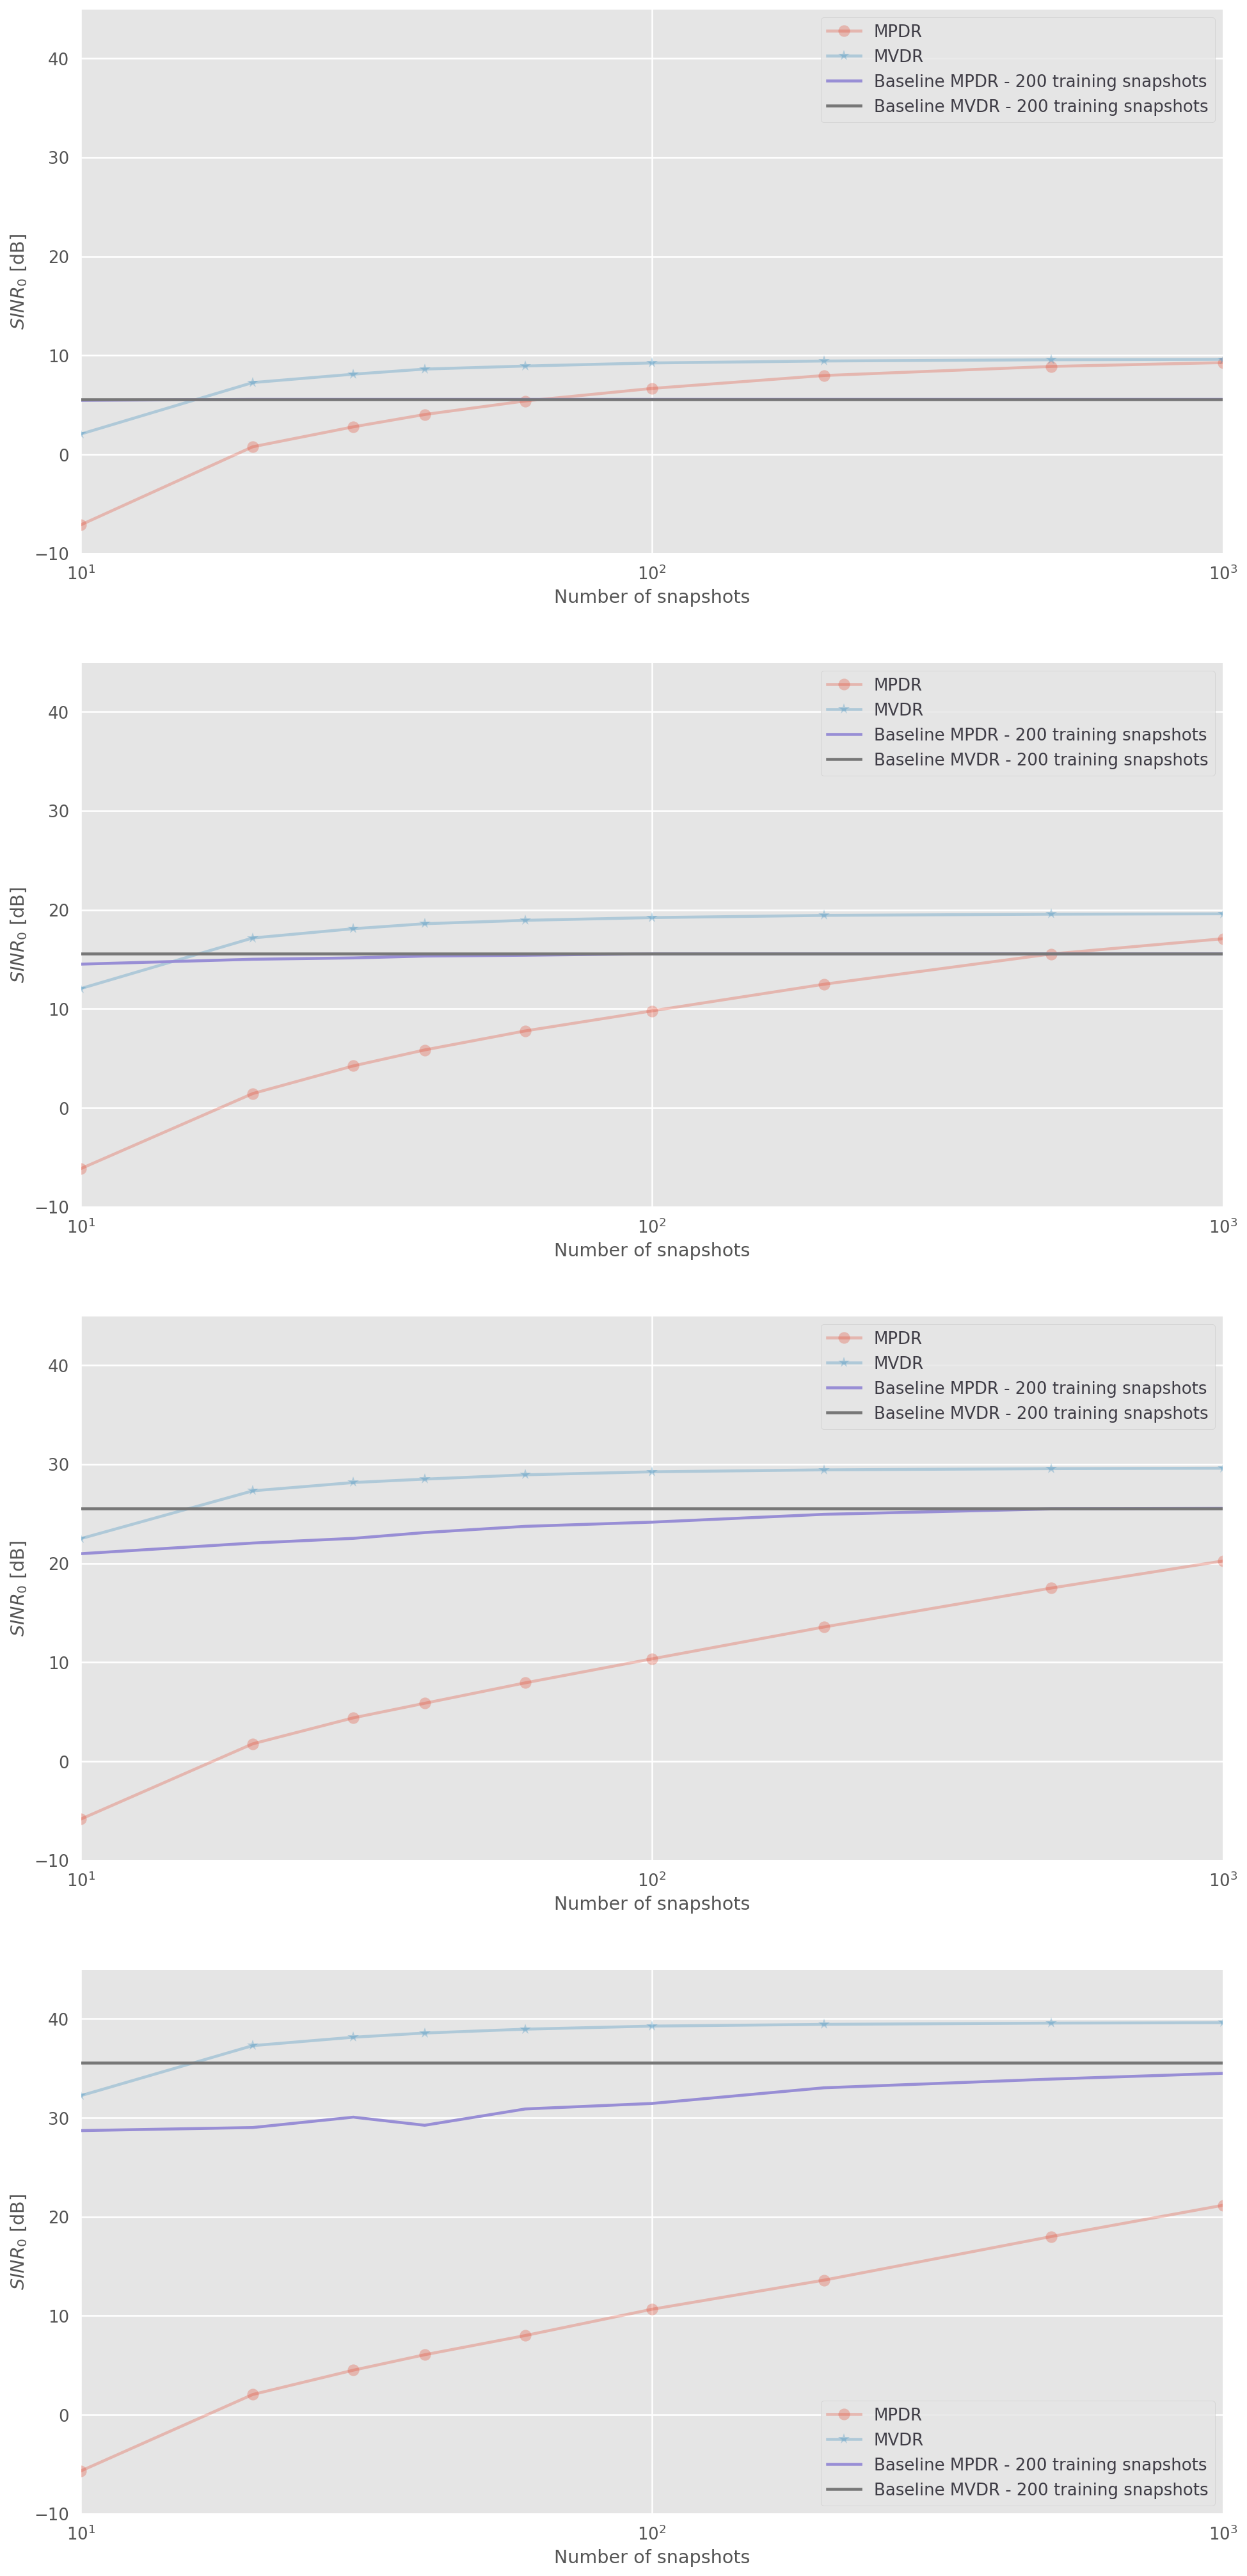

In [7]:
fig = plt.figure(figsize=(16, 9*n_SNRs)); 
for i_SNR in range(n_SNRs):
    sigma_s = 10**(SNRs[i_SNR] / 10)
    Rs = sigma_s * vs.dot(vs.transpose().conjugate())
    ax = fig.add_subplot(n_SNRs, 1, i_SNR+1)
    ax.semilogx(snapshots, 10*np.log10(sinr_snr_mpdr[i_SNR, :]), marker="o", alpha=0.3, label="MPDR")
    ax.semilogx(snapshots, 10*np.log10(sinr_snr_mvdr[i_SNR, :]), marker="*", alpha=0.3, label="MVDR")
#     ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mpdr[i_SNR, :]))
#     ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mvdr[i_SNR, :]))
    for i_training_snapshot in range(len(training_snapshots)):
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mpdr[i_training_snapshot, i_SNR, :]), 
                    label="Baseline MPDR - {} training snapshots".format(training_snapshots[i_training_snapshot]))
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mvdr[i_training_snapshot, i_SNR, :]), 
                    label="Baseline MVDR - {} training snapshots".format(training_snapshots[i_training_snapshot]))
    ax.legend()
    ax.set_xlim(10, 1000); ax.set_ylim(-10, 45);
    ax.set_xlabel("Number of snapshots");
    ax.set_ylabel(r"$SINR_0$ [dB]");
# fig.savefig("baseline_dl_various_interferences.jpg", dpi=600)    